In [ ]:
# Final Project Growia Beginer — Ichsan

<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">SETUP & LOAD DATA (STEP 1–2)</span></strong><br>
Setup & koneksi kebetulan saya pakai sql lite

In [38]:
# == STEP 1–2: Import library & koneksi SQL ==
import sqlite3, pandas as pd, numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
DB_PATH = Path("foo.db")

conn = sqlite3.connect("foo.db")
pd.options.display.float_format = '{:,.2f}'.format
print("✅ Connected:", "foo.db")


# === Helpers ===
def load_table(name, query=None):
    if query is None:
        query = f'SELECT * FROM {name}'
    df = pd.read_sql(query, conn)
    print(f"Loaded {name}: {len(df):,} rows")
    return df

def _to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '', regex=False).str.strip(), errors='coerce')

def classify_trend(series):
    # Return slope, relative change, and label (Up/Down/Flat) from a time-indexed series.
    s = series.reset_index(drop=True).astype(float).fillna(0.0)
    x = np.arange(len(s))
    if len(s) < 2:
        return 0.0, 0.0, "Flat"
    slope = np.polyfit(x, s, 1)[0]
    rel = (s.iloc[-1] - s.iloc[0]) / (abs(s.iloc[0]) + 1e-9)
    label = "Up" if slope > 0 else ("Down" if slope < 0 else "Flat")
    return float(slope), float(rel), label

✅ Connected: foo.db


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 3 – (awal): Muat tabel dasar OLIST</span></strong><br>


In [39]:
# == STEP 3 (awal): Muat tabel dasar OLIST ==
orders    = load_table("olist_orders_dataset", 
                       "SELECT order_id, customer_id, order_purchase_timestamp, "
                       "order_approved_at, order_delivered_carrier_date, "
                       "order_delivered_customer_date, order_estimated_delivery_date "
                       "FROM olist_orders_dataset")

customers = load_table("olist_customers_dataset", 
                       "SELECT customer_id, customer_unique_id, "
                       "customer_city AS address_city, customer_state AS address_state "
                       "FROM olist_customers_dataset")

items     = load_table("olist_order_items_dataset")
products  = load_table("olist_products_dataset", 
                       "SELECT product_id, product_category_name, product_weight_g "
                       "FROM olist_products_dataset")
payments  = load_table("olist_order_payments_dataset")
reviews   = load_table("olist_order_reviews_dataset")

# (opsional) translasi kategori ke Inggris jika ada
try:
    trans = load_table("product_category_name_translation")
    trans.columns = trans.columns.str.strip().str.lower()
    if "product_category_name" in trans and "product_category_name_english" in trans:
        trans_map = trans.set_index("product_category_name")["product_category_name_english"].to_dict()
    else:
        trans_map = None
except Exception:
    trans_map = None

# rapikan products
products["product_category_name"] = products["product_category_name"].astype(str).str.strip()
if trans_map:
    products["category_en"] = products["product_category_name"].map(trans_map).fillna(products["product_category_name"])
else:
    products["category_en"] = products["product_category_name"]
products["category_en"] = (products["category_en"].astype(str).str.replace("_"," ", regex=False).str.title())
products["product_weight_g"] = pd.to_numeric(products["product_weight_g"], errors="coerce")


# == STEP 3: Build FACT (1 baris / order) ==
# Pre-clean numerik
items["price"] = _to_num(items["price"])
items["freight_value"] = _to_num(items["freight_value"])
payments["payment_value"] = _to_num(payments["payment_value"])
payments["payment_installments"] = pd.to_numeric(payments["payment_installments"], errors="coerce").fillna(0).astype(int)
reviews["review_score"] = pd.to_numeric(reviews["review_score"], errors="coerce")

# 3.1 Items per order
items_agg = (items.groupby("order_id", observed=True)
             .agg(items_count=("order_item_id","count"),
                  unique_products=("product_id","nunique"),
                  unique_sellers=("seller_id","nunique"),
                  total_price=("price","sum"),
                  total_freight=("freight_value","sum"))
             .reset_index())

# 3.2 Payments per order (ambil tipe utama)
main_pay = (payments.sort_values(["order_id","payment_value"], ascending=[True,False])
            .drop_duplicates("order_id")[["order_id","payment_type"]]
            .rename(columns={"payment_type":"main_payment_type"}))

pay_agg = (payments.groupby("order_id", observed=True)
           .agg(total_payment=("payment_value","sum"),
                payment_installments=("payment_installments","max"))
           .reset_index()
           .merge(main_pay, on="order_id", how="left"))

# 3.3 Reviews per order (terbaru)
_rev = reviews.copy()
_rev["review_creation_date"] = pd.to_datetime(_rev["review_creation_date"], errors="coerce")
_rev.loc[~_rev["review_score"].between(1,5), "review_score"] = np.nan
_rev["has_title"]   = _rev["review_comment_title"].astype(str).str.strip().ne("").astype(int)
_rev["has_message"] = _rev["review_comment_message"].astype(str).str.strip().ne("").astype(int)
rev_latest = (_rev.sort_values("review_creation_date").drop_duplicates("order_id", keep="last"))
rev_agg = rev_latest[["order_id","review_score","has_title","has_message"]]

# 3.4 Merge FACT
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
fact = (orders.merge(customers, on="customer_id", how="left")
              .merge(items_agg, on="order_id",   how="left")
              .merge(pay_agg,  on="order_id",   how="left")
              .merge(rev_agg,  on="order_id",   how="left"))

for c in ["items_count","unique_products","unique_sellers","payment_installments"]:
    if c in fact: fact[c] = fact[c].fillna(0).astype(int)
for c in ["total_price","total_freight","total_payment"]:
    if c in fact: fact[c] = _to_num(fact[c]).fillna(0.0)

fact["total_order_value"] = fact.get("total_price", 0.0) + fact.get("total_freight", 0.0)
print("✅ FACT:", fact.shape)

Loaded olist_orders_dataset: 99,441 rows
Loaded olist_customers_dataset: 99,441 rows
Loaded olist_order_items_dataset: 112,650 rows
Loaded olist_products_dataset: 32,951 rows
Loaded olist_order_payments_dataset: 103,886 rows
Loaded olist_order_reviews_dataset: 99,224 rows
Loaded product_category_name_translation: 71 rows
✅ FACT: (99441, 22)


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 4 – Null Values (identifikasi & treatment)</span></strong><br>


In [40]:
# == STEP 4 – Null Values (identifikasi & treatment) — REPLACE CELL INI ==
import numpy as np
import pandas as pd

# Laporan awal missing
missing = fact.isna().sum().sort_values(ascending=False)
print("Missing (Top):\n", missing.head(10))

# 1) Flag review -> 0/1 (order tanpa review = 0, bukan NaN)
for c in ["has_title", "has_message"]:
    if c in fact.columns:
        fact[c] = fact[c].fillna(0).astype(int)

# 2) Pastikan kolom metode bayar utama ada & tidak NaN
if "main_payment_type" not in fact.columns:
    _main_pay = (
        payments.sort_values(["order_id", "payment_value"], ascending=[True, False])
        .drop_duplicates("order_id")[["order_id", "payment_type"]]
        .rename(columns={"payment_type": "main_payment_type"})
    )
    fact = fact.merge(_main_pay, on="order_id", how="left")

fact["main_payment_type"] = fact["main_payment_type"].fillna("Unknown").astype(str)

# 3) Kolom numerik lain: isi 0 supaya aman (kecuali review_score yang dibiarkan NaN)
num_cols = [
    "items_count","unique_products","unique_sellers","payment_installments",
    "total_price","total_freight","total_payment","total_order_value"
]
for c in num_cols:
    if c in fact.columns:
        fact[c] = pd.to_numeric(fact[c], errors="coerce").fillna(0)

# 4) Rekap missing setelah treatment
missing2 = fact.isna().sum().sort_values(ascending=False)
_nc = missing2[missing2 > 0].rename("n").to_frame()
_nc["pct"] = (_nc["n"] / len(fact) * 100).round(2)
_nc["handling"] = _nc.index.map({
    "review_score": "Biarkan NaN (order tanpa review)"
}).fillna("—")
display(_nc)


Missing (Top):
 review_score                     768
has_message                      768
has_title                        768
main_payment_type                  1
order_id                           0
customer_id                        0
order_delivered_customer_date      0
order_delivered_carrier_date       0
order_approved_at                  0
order_purchase_timestamp           0
dtype: int64


,n,pct,handling
review_score,768,0.77,Biarkan NaN (order tanpa review)


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 5 – Feature Engineering (time & values)</span></strong><br>


In [41]:
# --- STEP 5: Feature Engineering (time & values) ---
dt = pd.to_datetime(fact["order_purchase_timestamp"])
fact["year"]  = dt.dt.year
fact["month"] = dt.dt.month
fact["day_name"] = dt.dt.day_name()
fact["hour"] = dt.dt.hour

# time_of_day (tanpa warning)
h = fact["hour"]
fact["time_of_day"] = np.select(
    [
        h.le(5),
        h.gt(5) & h.le(11),
        h.gt(11) & h.le(17),
        h.gt(17) & h.le(21),
        h.gt(21),
    ],
    ["Night","Morning","Afternoon","Evening","Night"],
    default=pd.NA,
)

fact["time_of_day"] = fact["time_of_day"].astype(
    pd.CategoricalDtype(["Night","Morning","Afternoon","Evening"], ordered=True)
)


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 6 – CUSTOMER DEMOGRAPHIC</span></strong><br>


In [42]:
# == STEP 6: Customer Demographic ==
state_counts = (customers.groupby("address_state")["customer_unique_id"].nunique().reset_index(name="n_customers")
                .sort_values("n_customers", ascending=False))
city_counts  = (customers.groupby("address_city")["customer_unique_id"].nunique().reset_index(name="n_customers")
                .sort_values("n_customers", ascending=False))

orders_per_cust = (fact.groupby("customer_unique_id")["order_id"].nunique().reset_index(name="total_orders"))
orders_per_cust["order_frequency"] = np.where(orders_per_cust["total_orders"] < 5, "Sedikit", "Banyak")

first_last = (fact.groupby("customer_unique_id")["order_purchase_timestamp"]
              .agg(first_purchase="min", last_purchase="max").reset_index())
first_last["days_between"] = (first_last["last_purchase"] - first_last["first_purchase"]).dt.days
cust_summary = (orders_per_cust.merge(first_last, on="customer_unique_id", how="left"))


In [43]:
# === Tambah kolom terjemahan 'category_en' di sebelah kolom asli ===
import pandas as pd, unicodedata as ud

def _norm(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    # buang aksen + rapi lowercase + trim
    s = s.apply(lambda x: ud.normalize("NFKD", x).encode("ascii","ignore").decode("ascii") if pd.notna(x) else x)
    return s.str.strip().str.lower()

# 1) Ambil tabel translasi (pakai load_table milikmu kalau ada)
try:
    trans = load_table("product_category_name_translation")
except Exception:
    trans = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

# 2) Deteksi kolom sumber & english (nama bisa beda-beda)
t = trans.copy()
t.columns = t.columns.str.strip()
eng_col = next((c for c in t.columns if "english" in c.lower()), None)
src_col = next((c for c in t.columns if ("category" in c.lower() and "name" in c.lower() and "english" not in c.lower())), None)

# 3) Siapkan key normalisasi lalu join
products["product_category_name"] = products["product_category_name"].astype("string")
products["_key"] = _norm(products["product_category_name"])

if eng_col and src_col:
    t["_key"] = _norm(t[src_col].astype("string"))
    map_df = t[["_key", eng_col]].dropna().drop_duplicates("_key")
    products = products.merge(map_df, on="_key", how="left").rename(columns={eng_col: "category_en_raw"})
    # final kolom english (fallback ke nama asli jika tak ketemu)
    products["category_en"] = products["category_en_raw"].fillna(products["product_category_name"])
else:
    # kalau tabel translasi tidak sesuai/kolomnya beda -> pakai nama asli
    products["category_en"] = products["product_category_name"]

# 4) Rapikan tampilannya & tipe data
products["category_en"] = (products["category_en"]
                           .astype("string")
                           .str.replace("_"," ", regex=False)
                           .str.title())
products["category_en"] = products["category_en"].astype("category")

# 5) Letakkan 'category_en' PERSIS di sebelah kolom asli
cols = products.columns.tolist()
if "category_en" in cols:
    cols.remove("category_en")
    pos = cols.index("product_category_name") + 1
    cols = cols[:pos] + ["category_en"] + cols[pos:]
products = products[cols].drop(columns=["_key","category_en_raw"], errors="ignore")


# Catatan: hapus/komentari baris lama yang membuat category_en sebelum translasi (biar tidak saling timpa).


Loaded product_category_name_translation: 71 rows


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 7 – Order Behaviour</span></strong><br>


In [44]:
# pastikan dtype kategorikal sudah di-set di STEP 5
# fact["day_name"] = fact["day_name"].astype(pd.CategoricalDtype([...], ordered=True))
# fact["time_of_day"] = fact["time_of_day"].astype(pd.CategoricalDtype([...], ordered=True))

# == STEP 7: Order Behaviour (versi bebas warning) ==
cust_items = (fact.groupby("customer_unique_id", observed=True)
              .agg(orders=("order_id","nunique"),
                   total_items=("items_count","sum"))
              .assign(avg_items_per_order=lambda d: d["total_items"]/d["orders"])
              .reset_index()
              .merge(orders_per_cust[["customer_unique_id","order_frequency"]],
                     on="customer_unique_id", how="left"))

prod_weight = products["product_weight_g"].dropna()
weight_mean, weight_std, weight_n = prod_weight.mean(), prod_weight.std(), prod_weight.shape[0]

# >>> tambahkan observed=True di groupby yang pakai day_name/time_of_day <<<
freq_month_day = (fact.groupby(["year","month","day_name","time_of_day"], observed=True)
                  .size().reset_index(name="orders"))

top_time = (freq_month_day.sort_values(["year","month","orders"], ascending=[True,True,False])
            .groupby(["year","month","day_name"], observed=True, sort=False)
            .head(1).reset_index(drop=True))

cust_aov = (fact.groupby("customer_unique_id", observed=True)["total_order_value"]
            .mean().reset_index(name="avg_order_value"))
cust_aov["price_class"] = pd.cut(cust_aov["avg_order_value"],
                                 bins=[-np.inf,1000,2500,np.inf],
                                 labels=["Murah","Normal","Mahal"])

payment_popular = (fact.groupby("main_payment_type", observed=True)
                   .size().reset_index(name="orders")
                   .sort_values("orders", ascending=False))

# kategori produk: buat categoricals biar konsisten
products["category_en"] = products["category_en"].astype("category")


# gabungkan order-item dengan customer dan kategori (asli + english)
cust_cat = (items[["order_id","product_id"]]
            .merge(fact[["order_id","customer_unique_id"]].drop_duplicates(),
                   on="order_id", how="left")
            .merge(products[["product_id","product_category_name","category_en"]],
                   on="product_id", how="left"))

# preferensi kategori per customer
pref_counts = (cust_cat.groupby(["customer_unique_id","category_en"], observed=True, sort=False)
               .size().reset_index(name="orders"))

cust_top_category = (pref_counts.sort_values(["customer_unique_id","orders"], ascending=[True,False])
                     .groupby("customer_unique_id", observed=True, sort=False).head(1)
                     .rename(columns={"category_en":"top_category",
                                      "orders":"orders_in_top_category"}))

# items + timestamp + kategori untuk agregasi per tahun
items_time = (items.merge(orders[["order_id","order_purchase_timestamp"]], on="order_id", how="left")
                   .merge(products[["product_id","product_category_name","category_en"]], on="product_id", how="left"))
items_time["year"] = pd.to_datetime(items_time["order_purchase_timestamp"]).dt.year.astype(int)

# agregat per tahun & kategori (tampilkan nama asli + english)
cats_year = (items_time.dropna(subset=["category_en"])
             .groupby(["year","product_category_name","category_en"], observed=True, sort=False)
             .size().reset_index(name="count"))

# top-5 per tahun + ranking
top5_each_year = (cats_year.sort_values(["year","count"], ascending=[True,False])
                  .groupby("year", observed=True, sort=False).head(5).copy())
top5_each_year["rank_in_year"] = (top5_each_year.groupby("year")["count"]
                                  .rank(method="first", ascending=False).astype(int))

# pivot tren per tahun (kolom = english)
cat_trend = (cats_year.pivot(index="year", columns="category_en", values="count")
             .fillna(0).astype(int))




In [45]:
# Cek cepat
cats_year.head()         # harus ada: year, product_category_name, category_en, count
top5_each_year.head()    # harus ada kolom 'category_en' dan 'rank_in_year'


,year,product_category_name,category_en,count,rank_in_year
125,2016,moveis_decoracao,Furniture Decor,69,1
97,2016,beleza_saude,Health Beauty,51,2
110,2016,perfumaria,Perfumery,33,3
88,2016,brinquedos,Toys,27,4
107,2016,informatica_acessorios,Computers Accessories,21,5


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 8 – Review Customer</span></strong><br>


In [46]:
# == STEP 8 – Review Customer
import numpy as np
import pandas as pd

# Siapkan reviews (bersihkan skor & flag teks)
_rev = reviews.copy()
_rev["review_score"] = pd.to_numeric(_rev["review_score"], errors="coerce")
_rev.loc[~_rev["review_score"].between(1, 5), "review_score"] = np.nan
_rev["has_title"]   = _rev["review_comment_title"].astype(str).str.strip().ne("")
_rev["has_message"] = _rev["review_comment_message"].astype(str).str.strip().ne("")

# Hubungkan ke customer
rev_cust = (_rev.merge(orders[["order_id","customer_id"]], on="order_id", how="left")
                 .merge(customers[["customer_id","customer_unique_id"]], on="customer_id", how="left"))

# 8a) Rata-rata skor per customer + label puas/tidak
avg_review_per_cust = (rev_cust.groupby("customer_unique_id")["review_score"]
                       .mean().reset_index(name="avg_review"))
avg_review_per_cust["review_level"] = np.where(avg_review_per_cust["avg_review"] >= 4, "Puas", "Tidak Puas")

# 8b) Rasio review teks per transaksi (0..1) — dedup order
rev_text = rev_cust.loc[
    rev_cust["has_title"].astype(bool) & rev_cust["has_message"].astype(bool)
].drop_duplicates(["order_id"])

review_counts = (rev_text.groupby("customer_unique_id")["order_id"]
                 .nunique().reset_index(name="n_reviews"))

review_ratio = (orders_per_cust
                .merge(review_counts, on="customer_unique_id", how="left")
                .assign(
                    n_reviews=lambda d: d["n_reviews"].fillna(0).astype(int),
                    total_orders=lambda d: d["total_orders"].fillna(0).astype(int),
                    review_per_order=lambda d: np.where(
                        d["total_orders"] > 0,
                        (d["n_reviews"] / d["total_orders"]).clip(0, 1),
                        0.0
                    )
                ))

# (opsional) tampilkan ringkas
display(avg_review_per_cust.head())
display(review_ratio.head())


,customer_unique_id,avg_review,review_level
0,0000366f3b9a7992bf8c76cfdf3221e2,5.00,Puas
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.00,Puas
2,0000f46a3911fa3c0805444483337064,3.00,Tidak Puas
3,0000f6ccb0745a6a4b88665a16c9f078,4.00,Puas
4,0004aac84e0df4da2b147fca70cf8255,5.00,Puas


,customer_unique_id,total_orders,order_frequency,n_reviews,review_per_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1,Sedikit,1,1.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Sedikit,0,0.00
2,0000f46a3911fa3c0805444483337064,1,Sedikit,0,0.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,Sedikit,0,0.00
4,0004aac84e0df4da2b147fca70cf8255,1,Sedikit,0,0.00


<strong style="color:#daa520;"><span style="font-size:32px; font-weight:bold;">STEP 9 – Time Series & Seasonality</span></strong><br>


In [47]:
# == STEP 9: Time Series & Seasonality ==
fact["order_date"] = pd.to_datetime(fact["order_purchase_timestamp"]).dt.date
valid_mask = fact["order_date"].notna()

daily = (fact.loc[valid_mask]
         .groupby(pd.to_datetime(fact.loc[valid_mask,"order_date"]))
         .agg(orders=("order_id","nunique"),
              items=("items_count","sum"),
              revenue=("total_order_value","sum"))
         .rename_axis("date").reset_index())

daily_ma7 = (daily.set_index("date").rolling("7D").mean()
             .rename(columns={"orders":"orders_ma7","items":"items_ma7","revenue":"revenue_ma7"})
             .reset_index())

monthly = daily.set_index("date").resample("MS").sum().reset_index()
trend_orders  = classify_trend(monthly["orders"])
trend_items   = classify_trend(monthly["items"])
trend_revenue = classify_trend(monthly["revenue"])

print("Trend (Orders/Items/Revenue):", trend_orders, trend_items, trend_revenue)

daily["weekday"] = daily["date"].dt.day_name()
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_avg = daily.groupby("weekday")["orders"].mean().reindex(dow_order)
weekday_uplift = (weekday_avg / daily["orders"].mean() - 1).mul(100).round(2)


# == (Opsional) Export ringkasan ke folder outputs ==
from pathlib import Path
outdir = Path("outputs"); outdir.mkdir(exist_ok=True)
state_counts.to_csv(outdir/"step6_state_counts.csv", index=False)
city_counts.to_csv(outdir/"step6_city_counts.csv", index=False)
orders_per_cust.to_csv(outdir/"step6_orders_per_cust.csv", index=False)
cust_summary.to_csv(outdir/"step6_cust_summary.csv", index=False)

cust_items.to_csv(outdir/"step7_cust_items.csv", index=False)
payment_popular.to_csv(outdir/"step7_payment_popular.csv", index=False)
cust_top_category.to_csv(outdir/"step7_cust_top_category.csv", index=False)
top5_each_year.to_csv(outdir/"step7_top5_each_year.csv", index=False)
cat_trend.to_csv(outdir/"step7_cat_trend.csv")

avg_review_per_cust.to_csv(outdir/"step8_avg_review_per_cust.csv", index=False)
review_ratio.to_csv(outdir/"step8_review_ratio.csv", index=False)

daily.to_csv(outdir/"step9_daily.csv", index=False)
daily_ma7.to_csv(outdir/"step9_daily_ma7.csv", index=False)
monthly.to_csv(outdir/"step9_monthly.csv", index=False)
weekday_avg.to_csv(outdir/"step9_weekday_avg.csv")
print("✅ Exported CSVs to ./outputs")

Trend (Orders/Items/Revenue): (204.68000000000004, 0.0, 'Up') (233.36752136752142, -0.9999999998333333, 'Up') (32929.830769230764, -0.9999999999971811, 'Up')
✅ Exported CSVs to ./outputs


<strong style="color:#daa520;"><span style="font-size:35px; font-weight:bold;">VALIDATOR STEP 1–9 (PASS / FAIL)</span></strong><br>
Cek Keseluruhan Script


In [48]:
# === VALIDATOR STEP 1–9 (PASS / FAIL) ===
import pandas as pd, numpy as np, types, inspect

checks = []

def ok(name, cond, detail_ok="", detail_fail=""):
    checks.append({
        "Check": name,
        "Result": "PASS ✅" if bool(cond) else "FAIL ❌",
        "Details": detail_ok if cond else detail_fail
    })

def cols_exist(df, cols):
    return all(c in df.columns for c in cols)

# --- Step 1: Koneksi & load minimal kolom ---
ok("STEP 1: Orders minimal cols",
   'orders' in globals() and cols_exist(orders, ["order_id","customer_id","order_purchase_timestamp"]),
   f"{len(orders):,} rows",
   "orders/order_id/customer_id/order_purchase_timestamp tidak lengkap")

ok("STEP 1: Customers minimal cols",
   'customers' in globals() and cols_exist(customers, ["customer_id","customer_unique_id"]),
   f"{len(customers):,} rows",
   "customers columns tidak lengkap")

ok("STEP 1: Items minimal cols",
   'items' in globals() and cols_exist(items, ["order_id","product_id","order_item_id"]),
   f"{len(items):,} rows",
   "items columns tidak lengkap")

ok("STEP 1: Products minimal cols",
   'products' in globals() and cols_exist(products, ["product_id","product_category_name"]),
   f"{len(products):,} rows",
   "products columns tidak lengkap")

ok("STEP 1: Payments minimal cols",
   'payments' in globals() and cols_exist(payments, ["order_id","payment_value"]),
   f"{len(payments):,} rows",
   "payments columns tidak lengkap")

ok("STEP 1: Reviews minimal cols",
   'reviews' in globals() and cols_exist(reviews, ["order_id","review_score"]),
   f"{len(reviews):,} rows",
   "reviews columns tidak lengkap")

# --- Step 3: FACT 1-baris-per-order ---
ok("STEP 3: fact tersedia",
   'fact' in globals() and "order_id" in fact.columns,
   f"shape: {fact.shape}",
   "variabel 'fact' tidak ditemukan")

if 'fact' in globals():
    ok("STEP 3: 1 baris per order",
       fact.groupby("order_id").size().max() == 1,
       "tidak ada duplikasi order_id",
       "ada duplikasi baris per order_id di 'fact'")
    ok("STEP 3: jumlah order cocok",
       fact["order_id"].nunique() == orders["order_id"].nunique(),
       f"{fact['order_id'].nunique():,} = {orders['order_id'].nunique():,}",
       f"{fact['order_id'].nunique():,} != {orders['order_id'].nunique():,}")

# --- Step 4: Missing & konsistensi numerik ---
if 'fact' in globals():
    num_cols = [c for c in ["items_count","total_price","total_freight","total_payment","total_order_value"] if c in fact.columns]
    nonneg = all((fact[c] >= 0).all() for c in num_cols if c in fact)
    ok("STEP 4: nilai numerik non-negatif", nonneg, "", "ada nilai negatif di kolom numerik")

    # total_order_value ~ total_price + total_freight
    if all(c in fact.columns for c in ["total_order_value","total_price","total_freight"]):
        diff = (fact["total_order_value"] - (fact["total_price"]+fact["total_freight"])).abs().fillna(0)
        ok("STEP 4: total_order_value konsisten",
           (diff < 1e-6).all(),
           "", f"{(diff>=1e-6).sum()} baris tidak konsisten")

    # missing yang diizinkan hanya review_score
    miss = fact.isna().sum()
    bad_miss_cols = [c for c,v in miss.items() if v>0 and c not in ["review_score"]]
    ok("STEP 4: missing value terkontrol",
       len(bad_miss_cols) == 0,
       "hanya review_score yang boleh NaN",
       f"kolom dengan NaN: {bad_miss_cols}")

# --- Step 5: Feature time & buckets ---
if 'fact' in globals():
    ok("STEP 5: kolom waktu ada",
       all(c in fact.columns for c in ["year","month","day_name","hour"]),
       "", "kolom year/month/day_name/hour belum dibuat")

    if "time_of_day" in fact.columns:
        allowed_tod = {"Night","Morning","Afternoon","Evening"}
        tod_bad = set(pd.Series(fact["time_of_day"]).dropna().astype(str).unique()) - allowed_tod
        ok("STEP 5: time_of_day valid",
           len(tod_bad)==0,
           "OK", f"label tak dikenal: {tod_bad}")
    else:
        ok("STEP 5: time_of_day ada", False, "", "kolom 'time_of_day' tidak ditemukan")

# --- Step 6: Demografi & ringkasan customer ---
ok("STEP 6: orders_per_cust ada",
   'orders_per_cust' in globals() and all(c in orders_per_cust.columns for c in ["customer_unique_id","total_orders"]),
   f"{len(orders_per_cust):,} customers",
   "variabel 'orders_per_cust' belum dibuat")

ok("STEP 6: first/last purchase ada",
   'cust_summary' in globals() and all(c in cust_summary.columns for c in ["first_purchase","last_purchase"]),
   "", "variabel 'cust_summary' belum dibuat")

# --- Step 7: Perilaku order, kategori, pembayaran ---
# payment popular
pay_ok = False
if 'payment_popular' in globals():
    pay_ok = all(c in payment_popular.columns for c in ["orders"]) and len(payment_popular) > 0
ok("STEP 7: payment_popular ada", pay_ok, "", "variabel 'payment_popular' belum dibuat / kosong")

# kategori english tersedia?
cat_en_ok = 'category_en' in products.columns
ok("STEP 7: products.category_en tersedia", cat_en_ok, "", "kolom 'category_en' belum dibuat (jalankan langkah terjemahan)")

# cats_year / top5_each_year / cat_trend
ok("STEP 7: cats_year ada",
   'cats_year' in globals() and all(c in cats_year.columns for c in ["year","category_en","count"]),
   f"{len(cats_year):,} rows" if 'cats_year' in globals() else "",
   "variabel 'cats_year' belum dibuat")

ok("STEP 7: top5_each_year ada + ranking",
   'top5_each_year' in globals() and all(c in top5_each_year.columns for c in ["year","category_en","count","rank_in_year"]),
   f"{len(top5_each_year):,} rows" if 'top5_each_year' in globals() else "",
   "variabel 'top5_each_year' belum dibuat / kolom 'rank_in_year' hilang")

ok("STEP 7: cat_trend pivot ada",
   'cat_trend' in globals(),
   f"shape: {cat_trend.shape}" if 'cat_trend' in globals() else "",
   "variabel 'cat_trend' belum dibuat")

# translasi coverage (berapa % nama English beda dari asli)
if cat_en_ok:
    base = products["product_category_name"].astype(str).str.strip().str.lower()
    en   = products["category_en"].astype(str).str.strip().str.lower()
    coverage = (base != en).mean()
    ok("STEP 7: coverage terjemahan kategori",
       coverage > 0, f"{coverage*100:.1f}% kategori berbeda dari nama asli",
       "Terlihat belum ada perbedaan (mapping translasi mungkin belum diterapkan)")

# --- Step 8: Review metrics ---
if 'avg_review_per_cust' in globals():
    ok("STEP 8: avg_review_per_cust ada",
       all(c in avg_review_per_cust.columns for c in ["customer_unique_id","avg_review","review_level"]),
       f"{len(avg_review_per_cust):,} rows",
       "variabel 'avg_review_per_cust' belum dibuat")
if 'review_ratio' in globals():
    bounds_ok = review_ratio["review_per_order"].between(0,1, inclusive="both").all()
    ok("STEP 8: review_ratio 0..1",
       bounds_ok, "", "nilai 'review_per_order' di luar 0..1")

# --- Step 9: Time series ---
if 'daily' in globals():
    ok("STEP 9: daily ada",
       all(c in daily.columns for c in ["date","orders","items","revenue"]),
       f"{len(daily):,} rows",
       "variabel 'daily' belum dibuat")
if 'monthly' in globals():
    ok("STEP 9: monthly ada",
       all(c in monthly.columns for c in ["month","orders","items","revenue"]) or "date" in monthly.columns,
       f"{len(monthly):,} rows",
       "variabel 'monthly' belum dibuat")
if 'weekday_avg' in globals():
    ok("STEP 9: weekday_avg ada",
       isinstance(weekday_avg, (pd.Series,pd.DataFrame)) and len(weekday_avg)>0,
       f"{len(weekday_avg)} entries",
       "variabel 'weekday_avg' belum dibuat")

# --- Ringkasan hasil ---
result_df = pd.DataFrame(checks)
display(result_df)

# Fail summary (kalau ada)
fails = result_df[result_df["Result"].str.contains("FAIL")]
if len(fails):
    print("\n⚠️ Perlu diperbaiki pada cek berikut:")
    display(fails)
else:
    print("\n✅ Semua cek utama Step 1–9 PASS.")


,Check,Result,Details
0,STEP 1: Orders minimal cols,PASS ✅,"99,441 rows"
1,STEP 1: Customers minimal cols,PASS ✅,"99,441 rows"
2,STEP 1: Items minimal cols,PASS ✅,"112,650 rows"
3,STEP 1: Products minimal cols,PASS ✅,"32,951 rows"
4,STEP 1: Payments minimal cols,PASS ✅,"103,886 rows"
5,STEP 1: Reviews minimal cols,PASS ✅,"99,224 rows"
6,STEP 3: fact tersedia,PASS ✅,"shape: (99441, 28)"
7,STEP 3: 1 baris per order,PASS ✅,tidak ada duplikasi order_id
8,STEP 3: jumlah order cocok,PASS ✅,"99,441 = 99,441"
9,STEP 4: nilai numerik non-negatif,PASS ✅,



✅ Semua cek utama Step 1–9 PASS.


<strong style="color:#daa520;"><span style="font-size:35px; font-weight:bold;">VISUALSASI</span></strong><br>
Visualisasi Keseluruhan


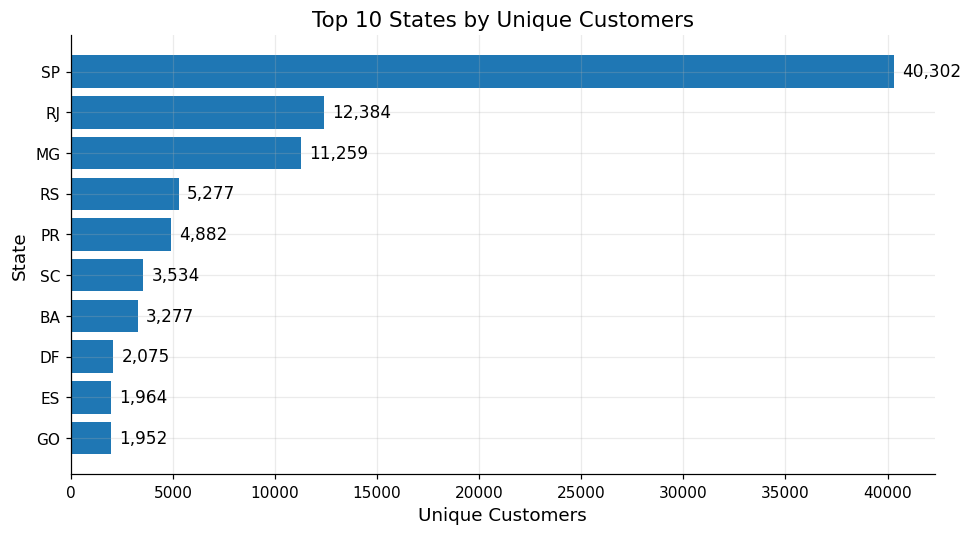

Saved: viz_polished\01_top10_states_customers.png


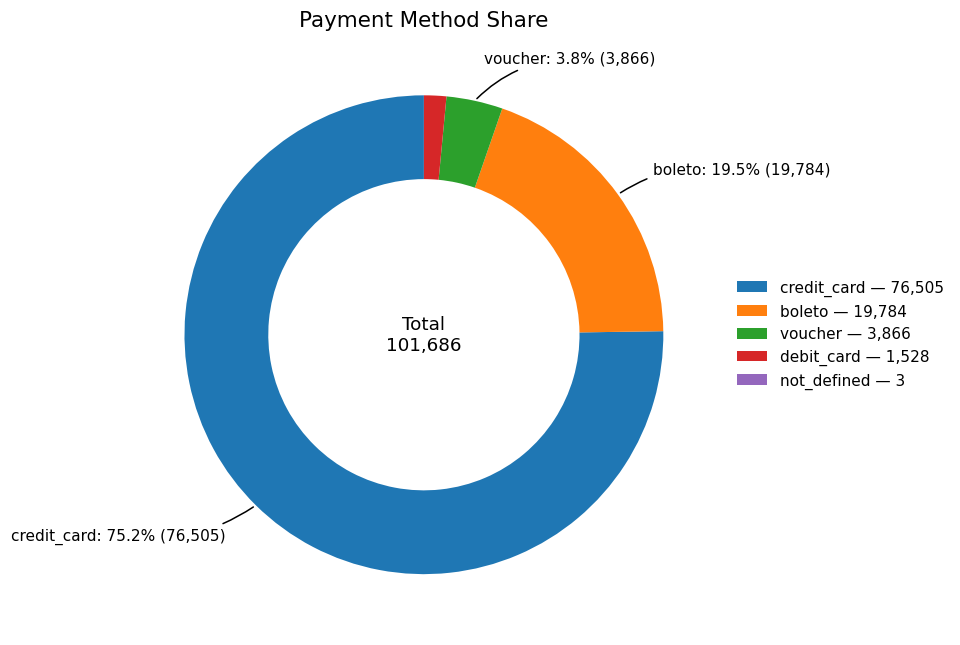

Saved: viz_polished\02_payment_donut_readable.png


C:\Users\Ichsa\AppData\Local\Temp\ipykernel_176\540602272.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("category_en")["order_id"].nunique()


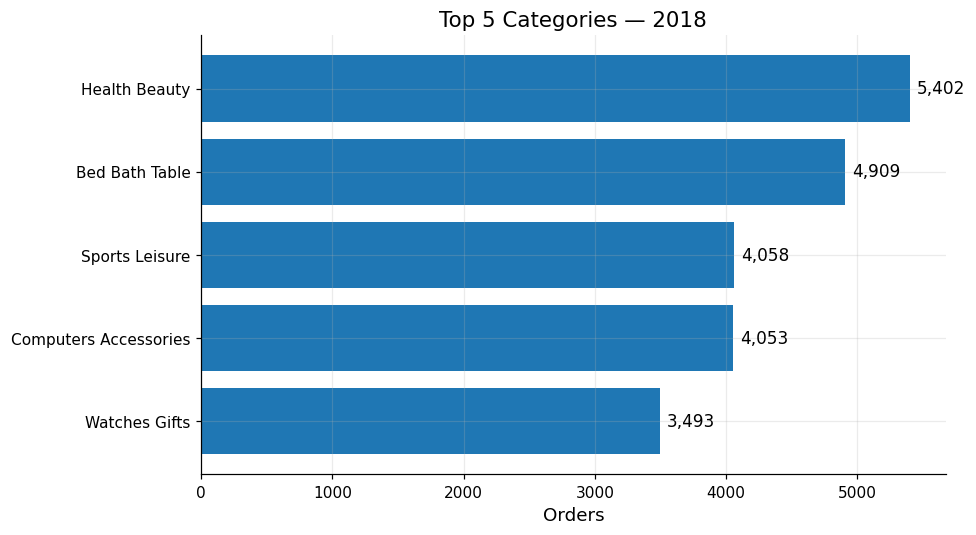

Saved: viz_polished\03_top5_categories_2018.png


C:\Users\Ichsa\AppData\Local\Temp\ipykernel_176\540602272.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["year","category_en"]).size().rename("orders").reset_index())
C:\Users\Ichsa\AppData\Local\Temp\ipykernel_176\540602272.py:187: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_k = (cat_count.groupby("category_en")["orders"].sum()


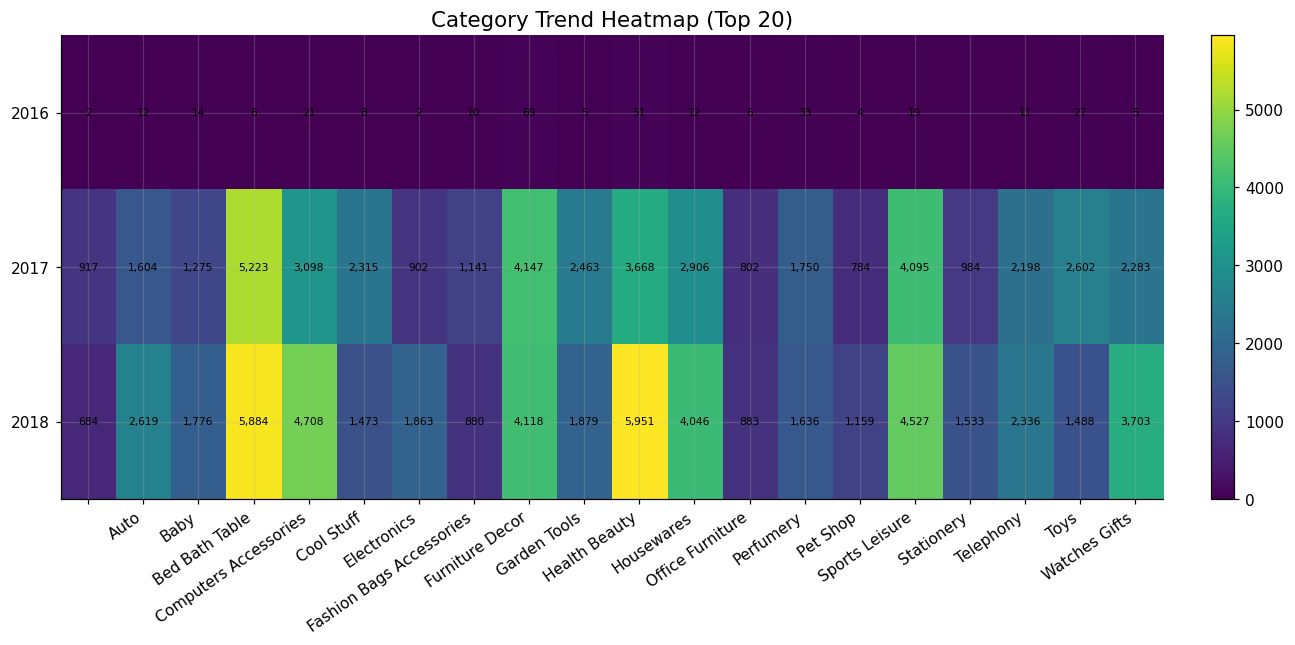

Saved: viz_polished\04_category_trend_heatmap_top20.png


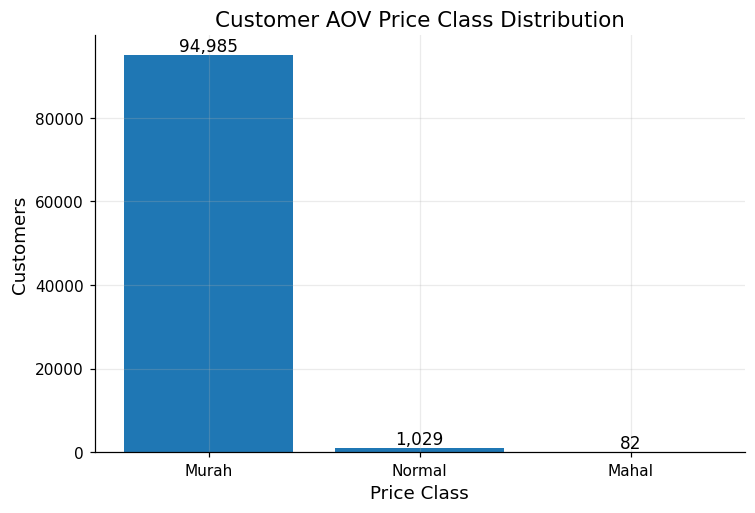

Saved: viz_polished\05_aov_price_class.png


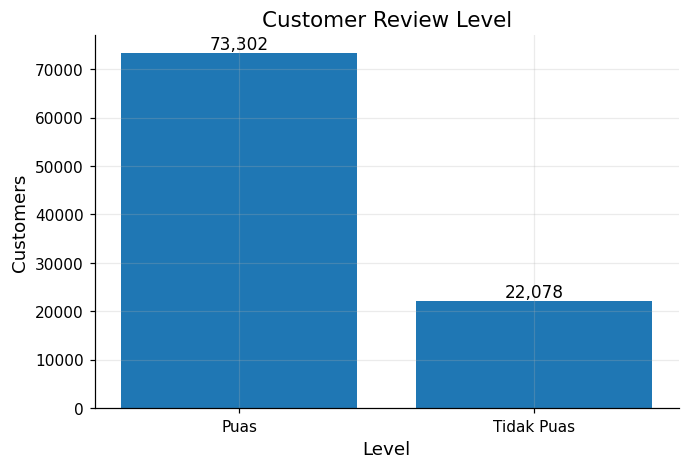

Saved: viz_polished\06_review_level.png


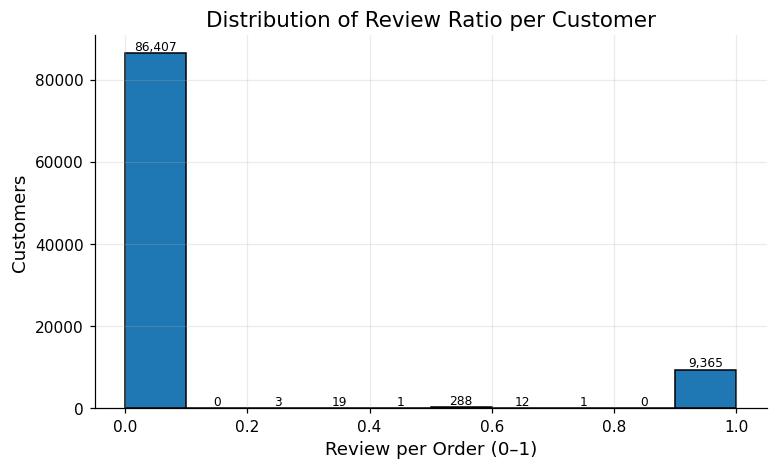

Saved: viz_polished\07_review_ratio_hist.png


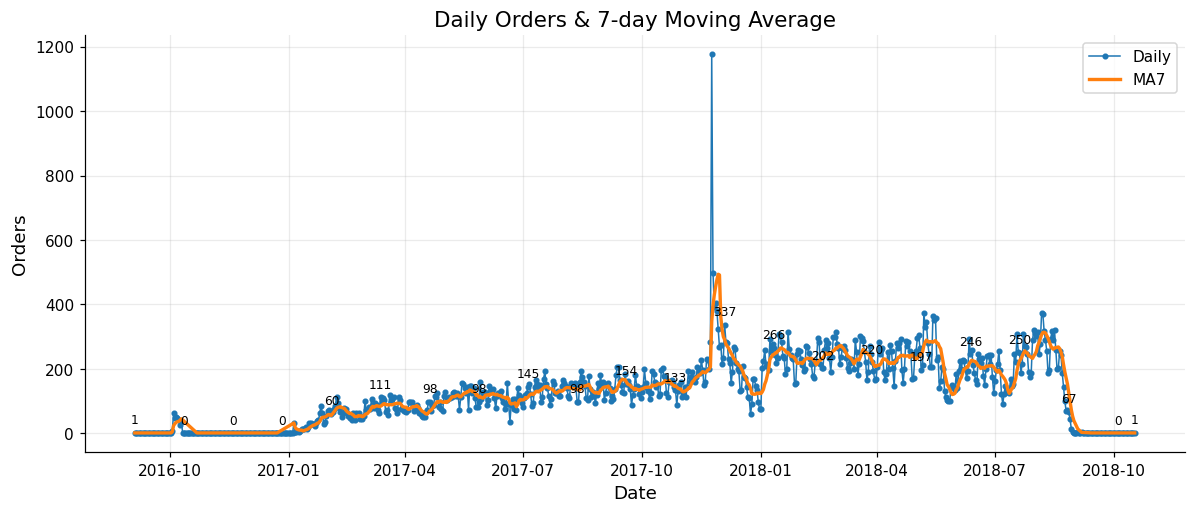

Saved: viz_polished\08_daily_orders_ma7.png


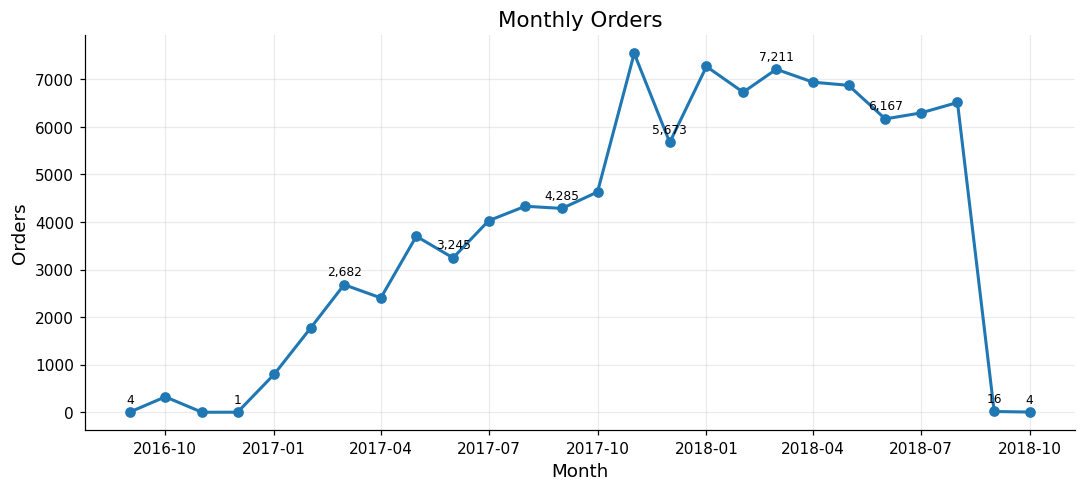

Saved: viz_polished\09_monthly_orders.png


C:\Users\Ichsa\AppData\Local\Temp\ipykernel_176\540602272.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = (dfh.groupby(["day_name","time_of_day"])["order_id"].nunique().unstack(fill_value=0))


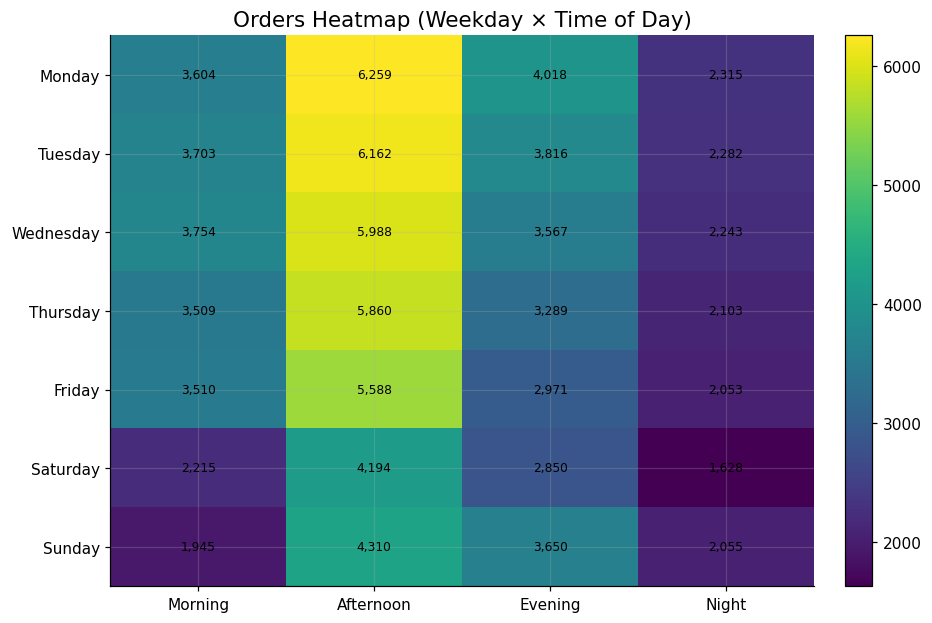

Saved: viz_polished\10_heatmap_weekday_time.png

✅ Visual polished tersimpan di folder: C:\Users\Ichsa\Downloads\Data Python Job\viz_polished


In [49]:
# ================================
# VISUALISASI “POLISHED + READABLE LABELS” (Step 6–9)
# ================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ------------------ Output folder ------------------
VIZ_DIR = Path("./viz_polished"); VIZ_DIR.mkdir(exist_ok=True)

# ------------------ Styling global ------------------
plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 180,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ------------------ Guards ------------------
for var in ["orders","customers","items","products","payments","reviews"]:
    if var not in globals():
        raise RuntimeError(f"Variabel '{var}' belum ada. Jalankan Step 1 (load) dulu.")

orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")

# ------------------ Helpers ------------------
def _fmt_int(v):
    try: return f"{int(round(float(v))):,}"
    except: return str(v)

def _bar_label_h(ax, pad_ratio=0.01):
    if not ax.patches: return
    xmax = max(p.get_width() for p in ax.patches)
    for p in ax.patches:
        w = p.get_width()
        ax.text(w + xmax*pad_ratio, p.get_y()+p.get_height()/2, _fmt_int(w),
                va="center", ha="left")

def _bar_label_v(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.text(p.get_x()+p.get_width()/2, h, _fmt_int(h),
                va="bottom", ha="center")

def _save(fig, name):
    fig.tight_layout()
    p = VIZ_DIR / name
    fig.savefig(p, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print("Saved:", p)

# ------------------ Fallbacks ringan ------------------
# Build fact minimal bila belum ada
if "fact" not in globals():
    tmp = orders.merge(customers, on="customer_id", how="left")
    ts = tmp["order_purchase_timestamp"]
    tmp["day_name"] = ts.dt.day_name()
    h = ts.dt.hour
    tmp["time_of_day"] = np.select(
        [h.le(5), h.gt(5)&h.le(11), h.gt(11)&h.le(17), h.gt(17)&h.le(21), h.gt(21)],
        ["Night","Morning","Afternoon","Evening","Night"], default=pd.NA
    )
    it = items.copy()
    it["price"] = pd.to_numeric(it["price"], errors="coerce")
    it["freight_value"] = pd.to_numeric(it["freight_value"], errors="coerce")
    ov = (it.groupby("order_id")[["price","freight_value"]].sum().sum(axis=1)
          .rename("total_order_value")).reset_index()
    fact = tmp.merge(ov, on="order_id", how="left").assign(total_order_value=lambda d: d["total_order_value"].fillna(0))

# category_en jika belum ada
if "category_en" not in products.columns:
    products["category_en"] = (products.get("product_category_name","").astype(str)
                               .str.replace("_"," ", regex=False).str.title())

# =========================================================
# 1) Top 10 States by Unique Customers
# =========================================================
state_top = (fact.groupby("address_state")["customer_unique_id"]
             .nunique().sort_values(ascending=False).head(10)[::-1])

fig = plt.figure(figsize=(9,5)); ax = fig.gca()
ax.barh(state_top.index.astype(str), state_top.values)
ax.set_title("Top 10 States by Unique Customers")
ax.set_xlabel("Unique Customers"); ax.set_ylabel("State")
_bar_label_h(ax)
_save(fig, "01_top10_states_customers.png")

# =========================================================
# 2) Payment Method Share — donut, label di luar + garis
# =========================================================
def plot_payment_donut(payments_df, fact_df=None, top_n=6, min_pct_label=2.0, savepath="02_payment_donut_readable.png"):
    # share dari payments (fallback ke fact.main_payment_type)
    if isinstance(payments_df, pd.DataFrame) and len(payments_df):
        pay_share = payments_df.groupby("payment_type")["order_id"].nunique().sort_values(ascending=False)
    elif fact_df is not None and "main_payment_type" in fact_df.columns:
        pay_share = fact_df.groupby("main_payment_type")["order_id"].nunique().sort_values(ascending=False)
    else:
        raise ValueError("Sumber payment tidak tersedia.")

    # kompres tail -> others
    if len(pay_share) > top_n:
        others = pay_share.iloc[top_n:].sum()
        pay_plot = pd.concat([pay_share.iloc[:top_n], pd.Series({"others": others})])
    else:
        pay_plot = pay_share.copy()

    labels = pay_plot.index.astype(str).tolist()
    vals   = pay_plot.values.astype(float)
    total  = float(vals.sum())
    pct    = vals / total * 100.0

    fig, ax = plt.subplots(figsize=(9, 6)); ax.set_aspect("equal")
    wedges = ax.pie(vals, startangle=90, wedgeprops={"width": 0.35})[0]
    ax.set_title("Payment Method Share")
    ax.text(0, 0, f"Total\n{_fmt_int(total)}", ha="center", va="center", fontsize=12)

    # posisi label di luar
    angles = np.array([(w.theta1 + w.theta2) / 2 for w in wedges]) * np.pi / 180.0
    x0, y0 = np.cos(angles), np.sin(angles)
    r_label = 1.18
    x, y = x0 * r_label, y0 * r_label

    # de-overlap sederhana
    order = np.argsort(y)
    y_sorted = y[order]; min_dy = 0.06
    for i in range(1, len(y_sorted)):
        if y_sorted[i] - y_sorted[i-1] < min_dy:
            y_sorted[i] = y_sorted[i-1] + min_dy
    y[order] = y_sorted

    for i, (lab, p, cnt, w) in enumerate(zip(labels, pct, vals, wedges)):
        if p < min_pct_label:  # kecil -> lewatkan label di chart
            continue
        xi, yi = x[i], y[i]; ha = "left" if xi > 0 else "right"
        xw, yw = x0[i]*1.0, y0[i]*1.0  # tepi donut
        ax.annotate(f"{lab}: {p:.1f}% ({_fmt_int(cnt)})",
                    xy=(xw,yw), xycoords="data",
                    xytext=(xi,yi), textcoords="data",
                    ha=ha, va="center", fontsize=10,
                    arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2"))

    # legend untuk semua kategori
    ax.legend([w for w in wedges],
              [f"{lab} — {_fmt_int(v)}" for lab, v in zip(labels, vals)],
              loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

    fig.tight_layout(); fig.savefig(VIZ_DIR/savepath, dpi=180, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print("Saved:", VIZ_DIR/savepath)

plot_payment_donut(payments_df=payments, fact_df=fact,
                   top_n=6, min_pct_label=2.0,
                   savepath="02_payment_donut_readable.png")

# =========================================================
# 3) Top 5 Categories (latest year)
# =========================================================
items_time = (items.merge(orders[["order_id","order_purchase_timestamp"]], on="order_id", how="left")
                   .merge(products[["product_id","category_en"]], on="product_id", how="left"))
items_time["year"] = pd.to_datetime(items_time["order_purchase_timestamp"]).dt.year

if items_time["year"].notna().any():
    latest_year = int(items_time["year"].max())
    top5 = (items_time.query("year == @latest_year")
            .groupby("category_en")["order_id"].nunique()
            .sort_values(ascending=False).head(5)[::-1])

    fig = plt.figure(figsize=(9,5)); ax = fig.gca()
    ax.barh(top5.index.astype(str), top5.values)
    ax.set_title(f"Top 5 Categories — {latest_year}")
    ax.set_xlabel("Orders")
    _bar_label_h(ax)
    _save(fig, f"03_top5_categories_{latest_year}.png")

# =========================================================
# 4) Category Trend Heatmap (Year × Category) — Top-20
# =========================================================
cat_count = (items_time.dropna(subset=["category_en"])
             .groupby(["year","category_en"]).size().rename("orders").reset_index())
top_k = (cat_count.groupby("category_en")["orders"].sum()
         .sort_values(ascending=False).head(20).index)
cat_pivot = (cat_count[cat_count["category_en"].isin(top_k)]
             .pivot(index="year", columns="category_en", values="orders")
             .fillna(0).astype(int))

fig = plt.figure(figsize=(12,6)); ax = fig.gca()
im = ax.imshow(cat_pivot.values, aspect="auto")
ax.set_yticks(range(len(cat_pivot.index))); ax.set_yticklabels(cat_pivot.index.astype(int))
ax.set_xticks(range(len(cat_pivot.columns))); ax.set_xticklabels(cat_pivot.columns, rotation=35, ha="right")
plt.colorbar(im, fraction=0.046, pad=0.04)
ax.set_title("Category Trend Heatmap (Top 20)")
for i in range(cat_pivot.shape[0]):
    for j in range(cat_pivot.shape[1]):
        v = cat_pivot.values[i, j]
        if v > 0:
            ax.text(j, i, _fmt_int(v), ha="center", va="center", fontsize=7)
_save(fig, "04_category_trend_heatmap_top20.png")

# =========================================================
# 5) AOV Price Class Distribution
# =========================================================
if "avg_order_value" in globals().get("cust_aov", pd.DataFrame()).columns:
    dist = cust_aov["price_class"].value_counts().reindex(["Murah","Normal","Mahal"]).fillna(0)
else:
    _cust_aov = (fact.groupby("customer_unique_id")["total_order_value"]
                 .mean().reset_index(name="avg_order_value"))
    _cust_aov["price_class"] = pd.cut(_cust_aov["avg_order_value"],
                                      [-np.inf, 1000, 2500, np.inf],
                                      labels=["Murah","Normal","Mahal"])
    dist = _cust_aov["price_class"].value_counts().reindex(["Murah","Normal","Mahal"]).fillna(0)

fig = plt.figure(figsize=(7,4.8)); ax = fig.gca()
ax.bar(dist.index.astype(str), dist.values)
ax.set_title("Customer AOV Price Class Distribution")
ax.set_xlabel("Price Class"); ax.set_ylabel("Customers")
_bar_label_v(ax)
_save(fig, "05_aov_price_class.png")

# =========================================================
# 6) Review Level & Ratio
# =========================================================
if "avg_review_per_cust" not in globals():
    _r = reviews.copy()
    _r["review_score"] = pd.to_numeric(_r["review_score"], errors="coerce")
    _r.loc[~_r["review_score"].between(1,5), "review_score"] = np.nan
    rc = (_r.merge(orders[["order_id","customer_id"]], on="order_id", how="left")
            .merge(customers[["customer_id","customer_unique_id"]], on="customer_id", how="left"))
    avg_review_per_cust = (rc.groupby("customer_unique_id")["review_score"]
                           .mean().reset_index(name="avg_review"))
    avg_review_per_cust["review_level"] = np.where(avg_review_per_cust["avg_review"] >= 4, "Puas", "Tidak Puas")

# Level
dist_level = avg_review_per_cust["review_level"].value_counts().reindex(["Puas","Tidak Puas"]).fillna(0)
fig = plt.figure(figsize=(6.4,4.4)); ax = fig.gca()
ax.bar(dist_level.index.astype(str), dist_level.values)
ax.set_title("Customer Review Level")
ax.set_xlabel("Level"); ax.set_ylabel("Customers")
_bar_label_v(ax)
_save(fig, "06_review_level.png")

# Ratio
if "review_ratio" not in globals():
    _r = reviews.copy()
    _r["has_title"] = _r["review_comment_title"].astype(str).str.strip().ne("")
    _r["has_message"] = _r["review_comment_message"].astype(str).str.strip().ne("")
    rev_text = _r.loc[_r["has_title"] & _r["has_message"]].drop_duplicates(["order_id"])
    oc = orders.merge(customers[["customer_id","customer_unique_id"]], on="customer_id", how="left")
    total_orders = oc.groupby("customer_unique_id")["order_id"].nunique().rename("total_orders")
    n_reviews = (rev_text.merge(orders[["order_id","customer_id"]], on="order_id", how="left")
                        .merge(customers[["customer_id","customer_unique_id"]], on="customer_id", how="left")
                        .groupby("customer_unique_id")["order_id"].nunique().rename("n_reviews"))
    review_ratio = (pd.concat([total_orders, n_reviews], axis=1).fillna(0)
                    .assign(review_per_order=lambda d: np.where(d["total_orders"]>0,
                                                               (d["n_reviews"]/d["total_orders"]).clip(0,1), 0.0))
                    .reset_index())

fig = plt.figure(figsize=(7.2,4.4)); ax = fig.gca()
vals = review_ratio["review_per_order"].values
bins = np.linspace(0, 1, 11)
counts, edges, _ = ax.hist(vals, bins=bins, edgecolor="black")
ax.set_title("Distribution of Review Ratio per Customer")
ax.set_xlabel("Review per Order (0–1)"); ax.set_ylabel("Customers")
for i in range(len(counts)):
    x = (edges[i] + edges[i+1]) / 2
    ax.text(x, counts[i], _fmt_int(counts[i]), ha="center", va="bottom", fontsize=8)
_save(fig, "07_review_ratio_hist.png")

# =========================================================
# 7) Time Series — Daily+MA7 & Monthly (robust)
# =========================================================
if "daily_full" not in globals():
    df = fact.copy()
    df["date"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.floor("D")
    daily_full = df.groupby("date")["order_id"].nunique().rename("orders").reset_index()
if "daily_ma7" not in globals():
    daily_ma7 = (daily_full.set_index("date")
                 .rolling("7D", min_periods=1).mean()
                 .rename(columns={"orders":"orders_ma7"}).reset_index())

# Daily + MA7
fig = plt.figure(figsize=(11,4.8)); ax = fig.gca()
ax.plot(daily_full["date"], daily_full["orders"], marker="o", markersize=3, linewidth=1, label="Daily")
ax.plot(daily_ma7["date"], daily_ma7["orders_ma7"], linewidth=2.2, label="MA7")
ax.set_title("Daily Orders & 7-day Moving Average")
ax.set_xlabel("Date"); ax.set_ylabel("Orders")
n = len(daily_full)
for i, (x,y) in enumerate(zip(daily_full["date"], daily_full["orders"])):
    if i % max(1, n//20) == 0 or i == n-1:
        ax.annotate(_fmt_int(y), (x,y), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
ax.legend()
_save(fig, "08_daily_orders_ma7.png")

# Monthly (robust kolom)
def _monthly_from_any(daily_full_df, monthly_df=None):
    df = None
    if isinstance(monthly_df, pd.DataFrame) and len(monthly_df):
        m = monthly_df.copy()
        remap = {c:"month" for c in m.columns if str(c).lower() in ("date","year_month")}
        if remap: m = m.rename(columns=remap)
        if {"month","orders"}.issubset(m.columns): df = m[["month","orders"]].copy()
    if df is None:
        df = (daily_full_df.set_index("date").resample("MS").sum()
              .reset_index().rename(columns={"date":"month"}))
    df["month"] = pd.to_datetime(df["month"])
    return df

monthly_plot = _monthly_from_any(daily_full, monthly if "monthly" in globals() else None)

fig = plt.figure(figsize=(10,4.6)); ax = fig.gca()
ax.plot(monthly_plot["month"], monthly_plot["orders"], marker="o", linewidth=2)
ax.set_title("Monthly Orders"); ax.set_xlabel("Month"); ax.set_ylabel("Orders")
for i, (x,y) in enumerate(zip(monthly_plot["month"], monthly_plot["orders"])):
    if i % 3 == 0 or i == len(monthly_plot) - 1:
        ax.annotate(_fmt_int(y), (x,y), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
_save(fig, "09_monthly_orders.png")

# Weekday × Time of Day (heatmap)
dfh = fact.copy()
if "day_name" not in dfh.columns:
    dfh["day_name"] = pd.to_datetime(dfh["order_purchase_timestamp"]).dt.day_name()
if "time_of_day" not in dfh.columns:
    h = pd.to_datetime(dfh["order_purchase_timestamp"]).dt.hour
    dfh["time_of_day"] = np.select(
        [h.le(5), h.gt(5)&h.le(11), h.gt(11)&h.le(17), h.gt(17)&h.le(21), h.gt(21)],
        ["Night","Morning","Afternoon","Evening","Night"], default=pd.NA
    )
pivot = (dfh.groupby(["day_name","time_of_day"])["order_id"].nunique().unstack(fill_value=0))
pivot = pivot.reindex(index=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                      columns=["Morning","Afternoon","Evening","Night"], fill_value=0)

fig = plt.figure(figsize=(8.6,5.8)); ax = fig.gca()
im = ax.imshow(pivot.values, aspect="auto")
ax.set_xticks(range(pivot.shape[1])); ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(pivot.shape[0])); ax.set_yticklabels(pivot.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
ax.set_title("Orders Heatmap (Weekday × Time of Day)")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        v = pivot.values[i, j]
        if v > 0:
            ax.text(j, i, _fmt_int(v), ha="center", va="center", fontsize=8)
_save(fig, "10_heatmap_weekday_time.png")

print("\n✅ Visual polished tersimpan di folder:", VIZ_DIR.resolve())
